In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
text_file = pathlib.Path('/ind-eng/ind.txt')

In [3]:
with open(text_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')[:-1]
text_pairs = []
for line in lines:
    eng, ind = line.split('\t')[:2]
    ind = "[start] " + ind + " [end]"
    text_pairs.append((eng, ind))

In [4]:
random.shuffle(text_pairs)
num_val_samples = int(0.05 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

8509 total pairs
7659 training pairs
425 validation pairs
425 test pairs


## Vectorizing the text data

In [5]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64

In [6]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [7]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length
)

ind_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_ind_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ind_vectorization.adapt(train_ind_texts)

In [8]:
import pickle
pickle.dump({'config': eng_vectorization.get_config(),
             'weights': eng_vectorization.get_weights()}
            , open("eng_vectorization.pkl", "wb"))

pickle.dump({'config': ind_vectorization.get_config(),
             'weights': ind_vectorization.get_weights()}
            , open("ind_vectorization.pkl", "wb"))

In [9]:
from_disk = pickle.load(open("eng_vectorization.pkl", "rb"))
eng_vectorization = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
# eng_vectorization.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
eng_vectorization.set_weights(from_disk['weights'])

from_disk = pickle.load(open("ind_vectorization.pkl", "rb"))
ind_vectorization = TextVectorization.from_config(from_disk['config'])
ind_vectorization.set_weights(from_disk['weights'])

In [10]:
def format_dataset(eng, ind):
    eng = eng_vectorization(eng)
    ind = ind_vectorization(ind)
    return ({"encoder_inputs": eng, "decoder_inputs": ind[:, :-1],}, ind[:, 1:])

In [11]:
def make_dataset(pairs):
    eng_texts, ind_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ind_texts = list(ind_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ind_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

In [12]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [13]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


## Building the model

In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

In [15]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config

In [16]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [17]:
embed_dim = 256
latent_dim = 2048
num_heads = 16

In [18]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

In [19]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.6)(x)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

In [20]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

## Training

In [21]:
epochs = 60

transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   5258752     ['positional_embedding[

In [22]:
transformer.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
hist = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/60
120/120 [==============================] - 168s 1s/step - loss: 1.9636 - accuracy: 0.2801 - val_loss: 1.7246 - val_accuracy: 0.3383
Epoch 2/60
120/120 [==============================] - 165s 1s/step - loss: 1.6781 - accuracy: 0.3546 - val_loss: 1.6270 - val_accuracy: 0.3679
Epoch 3/60
120/120 [==============================] - 165s 1s/step - loss: 1.5995 - accuracy: 0.3762 - val_loss: 1.5769 - val_accuracy: 0.3936
Epoch 4/60
120/120 [==============================] - 165s 1s/step - loss: 1.5476 - accuracy: 0.3927 - val_loss: 1.5471 - val_accuracy: 0.3968
Epoch 5/60
120/120 [==============================] - 165s 1s/step - loss: 1.5067 - accuracy: 0.4062 - val_loss: 1.5113 - val_accuracy: 0.4097
Epoch 6/60
120/120 [==============================] - 149s 1s/step - loss: 1.4638 - accuracy: 0.4191 - val_loss: 1.4832 - val_accuracy: 0.4149
Epoch 7/60
120/120 [==============================] - 136s 1s/step - loss: 1.4200 - accuracy: 0.4310 - val_loss: 1.4750 - val_accuracy: 0.4093

Epoch 58/60
120/120 [==============================] - 178s 1s/step - loss: 0.7041 - accuracy: 0.7058 - val_loss: 1.3980 - val_accuracy: 0.4834
Epoch 59/60
120/120 [==============================] - 171s 1s/step - loss: 0.7008 - accuracy: 0.7079 - val_loss: 1.3988 - val_accuracy: 0.4939
Epoch 60/60
120/120 [==============================] - 156s 1s/step - loss: 0.6940 - accuracy: 0.7116 - val_loss: 1.4060 - val_accuracy: 0.4965


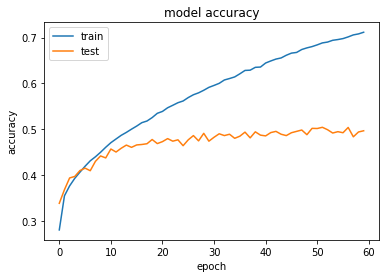

In [23]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

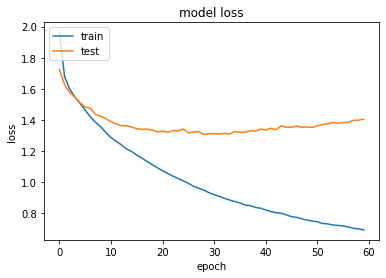

In [24]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing

In [25]:
ind_vocab = ind_vectorization.get_vocabulary()
ind_index_lookup = dict(zip(range(len(ind_vocab)), ind_vocab))
max_decoded_sentence_length = 20

In [26]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ind_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ind_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
               
        if sampled_token == "[end]":
            break    
    decoded_sentence = decoded_sentence.replace('[start] ', '')
    decoded_sentence = decoded_sentence.replace(' [end]', '')

    return decoded_sentence

In [27]:
avg_bleu = 0.0
smooth = SmoothingFunction()
for _ in range(50):
    input_sentence, target_sentence = random.choice(test_pairs)
    translation = decode_sequence(input_sentence)
    
    target_sentence = target_sentence.replace('[start] ', '')
    target_sentence = target_sentence.replace(' [end]', '')
    target_sentence = re.sub(r'[^\w\s]', '', target_sentence)
    target_sentence = target_sentence.lower()
    
    ref_corpus = target_sentence.split(' ')
    translation_corpus = translation.split(' ')
    bleu = sentence_bleu([target_sentence], translation, smoothing_function=smooth.method1)
    avg_bleu += bleu
    
    print(f'Input sentence: {input_sentence}')
    print(f'Target sentence: {target_sentence}')
    print(f'Translation: {translation}')
    print(f'BLEU: {bleu}')
    print('##########################################')

Input sentence: I hope you like it.
Target sentence: aku harap kau menyukainya
Translation: aku harap kau salah
BLEU: 0.5374832544636091
##########################################
Input sentence: I don't think I've seen you before.
Target sentence: aku pikir aku belum pernah bertemu denganmu sebelumnya
Translation: aku kira aku penasaran padamu
BLEU: 0.16508048918210555
##########################################
Input sentence: Tom has been quite cooperative.
Target sentence: tom sudah cukup kooperatif sejauh ini
Translation: tom sudah mendapat tidak yang ingin ingin yang ingin dengan yang ingin yang mudah
BLEU: 0.15196379737673965
##########################################
Input sentence: We just met Tom.
Target sentence: kami baru saja bertemu tom
Translation: kita baru bertemu dengan tom
BLEU: 0.5713353836987581
##########################################
Input sentence: He made all of the clothes himself.
Target sentence: semua bajunya dibuat oleh dia sendiri
Translation: dia membua

Input sentence: I don't think I've seen you before.
Target sentence: aku pikir aku belum pernah bertemu denganmu sebelumnya
Translation: aku kira aku penasaran padamu
BLEU: 0.16508048918210555
##########################################
Input sentence: He's my brother.
Target sentence: dia kakak lakilakiku
Translation: dia adikku
BLEU: 0.13448025110102005
##########################################
Input sentence: Tom seems bewildered.
Target sentence: tom sepertinya bimbang
Translation: tom terlihat
BLEU: 0.12125982739015963
##########################################
Input sentence: Tom put on his raincoat.
Target sentence: tom memakai jas hujan
Translation: tom mengenakan kamu
BLEU: 0.32996156842059315
##########################################
Input sentence: The pain hasn't gone away.
Target sentence: penyakitnya belum sembuh
Translation: itu tidak sampai akan pergi
BLEU: 0.03333333333333335
##########################################
Input sentence: Do you want anything to eat?
Targe

In [28]:
avg_bleu /= 50
print(f'Average BLEU: {avg_bleu}')

Average BLEU: 0.4224414487242287


In [29]:
transformer.save('eng-ind_translator.h5')